# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of SBVS, molecular descriptors and machine learning techniques for identifying active and inactive compounds given an SARS-CoV-2 assay. [PostEra.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

1. [Reading data](#reading_data)
2. [Machine learning](#machine_learning)    
    a. [Evaluation metrics](#evaluation_metrics)    
    b. [Constructing the models](#constructing_models)    
3. [Performace analysis](#performance_analysis)     
    a. [Comparing different models and rescaling methods](#comparing)    
    b. [Finding the best subset](#finding)     
    c. [ROC curves](#roc_curves)

<a id='reading_data'></a>
## Reading data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Activity data

In [2]:
def write_data():
    import requests
    
    url = 'https://covid.postera.ai/covid/activity_data.csv'
    r = requests.get(url, allow_redirects=True)

    with open('activity_data.csv', 'wb') as f:
        f.write(r.content)
        
## Fetch activity data
#write_data()

# Read activity data
activity = pd.read_csv('activity_data.csv')

,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69973
f_inhibition_at_50_uM,0.69973,1.00000


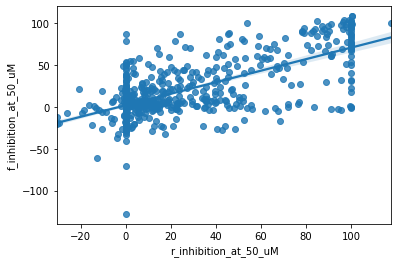

In [3]:
# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(x=activity['r_inhibition_at_50_uM'], y=activity['f_inhibition_at_50_uM'])
activity[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

### Molecular docking and molecular descriptors

In [4]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)

# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)

# Merge top scores and experimental data
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, activity[['CID','r_inhibition_at_50_uM','r_avg_IC50','f_inhibition_at_50_uM','f_avg_IC50']])
del tmp

# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Merge descriptors to "top"
data = pd.merge(top, descriptors)
data.rename({'VABC Volume Descriptor': 'Volume', 'Rotatable Bonds Count': 'Rotatable Bonds', 'Topological Polar Surface Area': 'TPSA'}, axis=1, inplace=True)

# Label actives and inactives in relation to "RapidFire"
data['r_active'] = data['r_inhibition_at_50_uM'] > 50
data['r_active'] = data['r_active'].astype(int) # 1 for active, 0 for inactive

# Label actives and inactives in relation to the fluorescence assay
data['f_active'] = data['f_inhibition_at_50_uM'] > 50
data['f_active'] = data['f_active'].astype(int) # 1 for active, 0 for inactive

data

,CID,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP,r_active,f_active
0,MAR-UNI-c84db004-13,-9.0,6.586498,-85.9230,7.447876,0.000000,NaN,NaN,NaN,424.84863706529114,6,111.52,510.131468,5.100,0,0
1,BAR-COM-4e090d3a-53,-7.5,7.221692,-83.8857,7.340981,0.000000,NaN,16.960570,NaN,275.6888879402175,6,93.21,312.122240,-0.187,0,0
2,TRY-UNI-714a760b-6,-6.4,6.377253,-68.7197,6.414523,NaN,13.895165,81.756960,24.566619,231.72693004306151,5,41.99,260.071641,2.401,0,1
3,EDJ-MED-c9f55a56-1,-6.2,5.491030,-69.4555,6.042434,4.870901,NaN,0.403773,NaN,206.5538721380282,5,70.67,230.116761,1.169,0,0
4,LON-WEI-0a73fcb8-7,-7.4,6.677942,-73.4504,6.826287,58.930356,66.350807,84.229060,13.671987,271.54289399511737,5,71.45,318.077120,1.647,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,MED-COV-4280ac29-14,-6.5,6.078443,-64.1177,6.060790,0.000000,NaN,5.547850,NaN,254.05361544442258,3,40.62,278.082205,1.915,0,0
939,DAR-DIA-842b4336-13,-5.9,6.208389,-72.0692,6.147168,NaN,NaN,11.500410,NaN,200.9844589238615,4,70.23,252.012412,0.862,0,0
940,MAK-UNK-d4768348-1,-6.1,7.048776,-68.5433,7.249597,NaN,0.484415,73.746190,1.630843,248.1690985087169,4,66.07,310.021262,-0.558,0,1
941,CHR-SOS-7098f804-3,-6.9,6.042820,-76.6604,6.431856,5.996569,NaN,-15.617840,NaN,238.16516681807818,6,92.47,292.025084,3.530,0,0


<a id='machine_learning'></a>
## Machine learning

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBRegressor

import multiprocessing
from functools import partial

import itertools
import time

<a id='constructing_models'></a>
### Constructing the models

In [6]:
# Get all subsets of a "main" list and N other lists
def get_combinations(min_len, list1, *args):
    combinations = []
    for sublist in args:
        list2 = list1 + sublist
        combinations += list(itertools.chain.from_iterable(itertools.combinations(list2, r) for r in range(min_len, len(list2)+1)))
    
    # Remove duplicates and return list
    return list(dict.fromkeys(combinations))

In [7]:
# Rebalance data with SMOTE and cross validate model
def get_mean_scores(data, scoring_metrics, train_set, subset, activity_label, model, scaler=None):
    # Drop NaN activity and descriptor values
    new_data = data.dropna(subset=[activity_label, *subset])
    y = new_data[activity_label]
    X = new_data[subset]
    
    if scaler is not None:
        # Scale data to [0, 1]
        X = scaler.fit_transform(X)
    
    pipe = make_pipeline(SMOTE(random_state=42), model)

    mean_scores = [np.mean(i) for i in cross_validate(pipe, X, y, scoring=scoring_metrics).values()]
    mean_scores.append(activity_label)
    mean_scores.append(str(model).split('(')[0])
    mean_scores.append(str(scaler).split('(')[0])
    
    # Add binary list of the descriptors present (True) or not present (False) in the subset
    mean_scores.extend([1 if i in subset else 0 for i in train_set])
    
    return mean_scores

In [8]:
def run_models(data, combinations, train_set, scoring_metrics, columns):
    # DataFrame for all models' scores
    scores_data = pd.DataFrame()

    model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                     RandomForestClassifier(n_estimators=10, random_state=13), 
                     KNeighborsClassifier(n_neighbors=3), 
                     LinearSVC(dual=False, random_state=13)]#,
                     #XGBRegressor(objective='reg:squarederror', random_state=13)]
    scaler_list = [None, RobustScaler(), MinMaxScaler(), StandardScaler()]
        
    # Loop through all subset combinations (2, N)
    for subset in combinations:
        subset = list(subset)
        
        # Arguments for pool.map
        args = []

        for activity_label in ['r_active','f_active']:
            for model in model_list:
                for scaler in scaler_list:                    
                    args.append((activity_label, model, scaler))

        # Define number of processes
        ncpu = multiprocessing.cpu_count()
        with multiprocessing.Pool(processes=ncpu-1) as pool:
            scores = pool.starmap(partial(get_mean_scores, data, scoring_metrics, train_set, subset), args)

        # Append scores to all scores
        scores = pd.DataFrame(scores, columns=columns+train_set)
        scores_data = scores_data.append(scores)
    
    return scores_data

<a id='evaluation_metrics'></a>
### Evaluation metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [9]:
# Descriptors
descriptor_list = ['Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP']
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']

train_set = descriptor_list + docking_list

# Get combinations of the molecule descriptors /
#                         molecule descriptors + "qvina" and/or "rfscore_qvina" /
#                         molecule descriptors + "plants" and/or "rfscore_plants"
combinations = get_combinations(2, descriptor_list, 
                                ['qvina','rfscore_qvina'], 
                                ['plants','rfscore_plants'])
# Test metrics
scoring_metrics = ['accuracy','f1','precision','recall','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]

columns = ['fit_time', 'score_time', *test_metrics, 'activity_label', 'model', 'scaler']

In [10]:
t0 = time.time()

## Run all!
#scores_data = run_models(data, combinations, train_set, scoring_metrics, columns)
    
t1 = time.time()
print('{:g}m:{:g}s'.format(*divmod(t1 - t0, 60)))

#scores_data.drop(['fit_time','score_time'], axis=1, inplace=True)
#scores_data.to_csv('scores_data.csv', index=False)

0m:0.000110149s


<a id='performance_analysis'></a>
## Performance analysis

In [11]:
# Read test scores and sort values
scores_data = pd.read_csv('scores_data.csv')
columns = scores_data.columns

scores_data['test_mean'] = scores_data[test_metrics].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.head()

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,activity_label,model,scaler,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
3597,0.718963,0.412821,0.296750,0.683598,0.736900,r_active,LinearSVC,RobustScaler,1,1,1,1,1,1,0,0,0,0.569806
3599,0.716847,0.410737,0.294733,0.683598,0.737172,r_active,LinearSVC,StandardScaler,1,1,1,1,1,1,0,0,0,0.568617
1177,0.741236,0.411970,0.301172,0.656125,0.724504,f_active,KNeighborsClassifier,RobustScaler,0,1,1,1,0,0,0,0,0,0.567001
3587,0.711539,0.406024,0.289907,0.683598,0.737712,r_active,LogisticRegression,StandardScaler,1,1,1,1,1,1,0,0,0,0.565756
1179,0.742311,0.403335,0.297151,0.633618,0.727672,f_active,KNeighborsClassifier,StandardScaler,0,1,1,1,0,0,0,0,0,0.560817


<a id='comparing'></a>
### Comparing different models and rescaling methods

In [12]:
melt = pd.melt(scores_data, id_vars=columns[5:], value_vars=columns[:5])

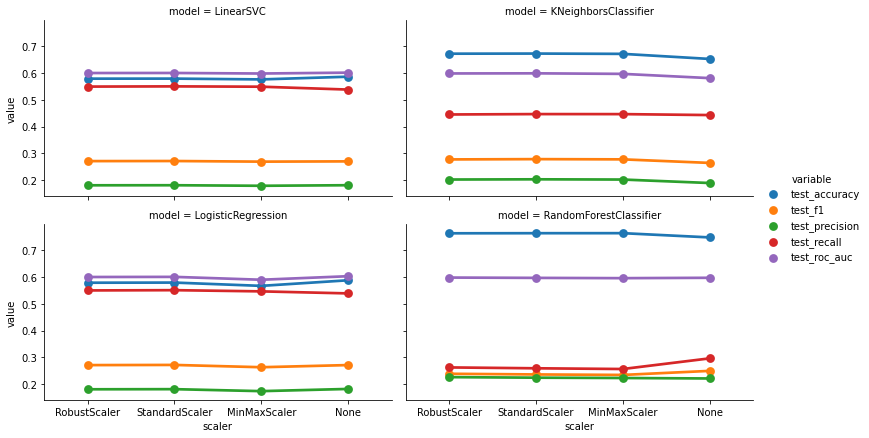

In [13]:
sns.catplot(kind='point', data=melt, x='scaler', y='value', hue='variable', col='model', col_wrap=2, height=3, aspect=1.75)

It is noticeable that rescaling the data had minimal impact on the results. Thus, no rescaling will be applied to the final models. 

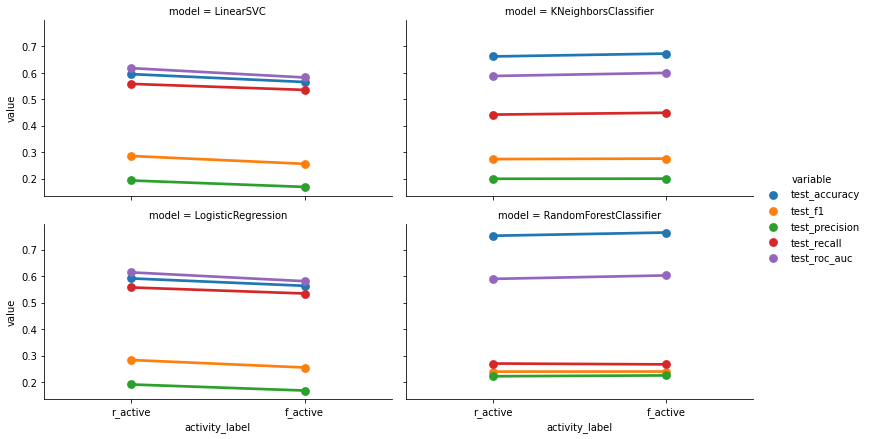

In [14]:
sns.catplot(kind='point', data=melt, x='activity_label', y='value', hue='variable', col='model', col_wrap=2, height=3, aspect=1.75)

We see here the best classification metric ("RapidFire" or fluorescence) varies a bit for each model. While Linear SVC and Logistic Regression performed better with "RapidFire" activity labels, K-Nearest Neighbors and Random Forest classifiers performed better with the fluorescence activity labels.
<a id='finding'></a>
### Finding the best subset

In [15]:
new_scores_data = scores_data.query('scaler == "None"').drop('scaler', axis=1)
new_scores_data.groupby('model').head(1)

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,activity_label,model,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
3512,0.744416,0.397669,0.295948,0.609972,0.726020,f_active,KNeighborsClassifier,0,1,1,0,1,1,1,0,0,0.554805
5956,0.822881,0.405662,0.394776,0.419312,0.701409,r_active,RandomForestClassifier,1,1,1,1,0,0,0,1,0,0.548808
3808,0.702026,0.385764,0.276166,0.646825,0.731529,r_active,LogisticRegression,1,1,1,1,1,1,1,0,0,0.548462
2124,0.698818,0.375315,0.269300,0.624603,0.726159,r_active,LinearSVC,1,0,1,1,1,0,0,0,0,0.538839


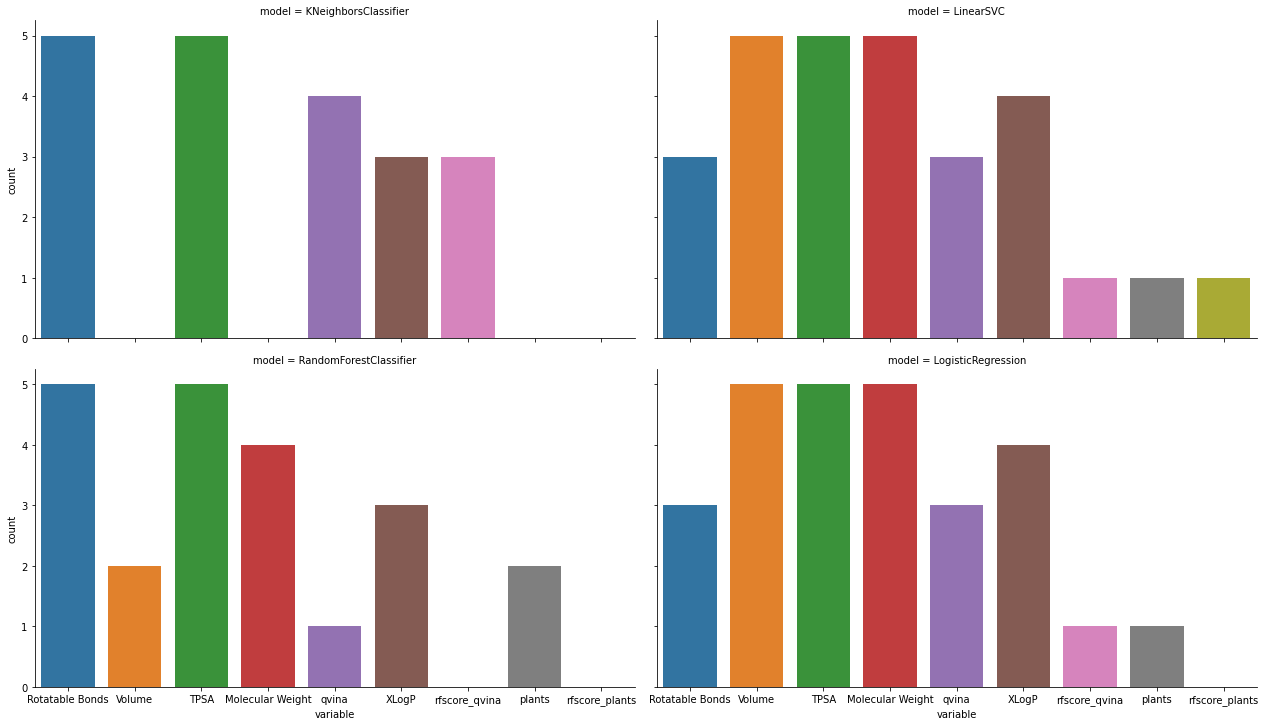

In [16]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(new_scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(new_scores_data, id_vars=[*test_metrics,'activity_label','model','test_mean'], value_vars=train_set, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', col_wrap=2, aspect=1.75)

The frequency count shows the most recurring descriptors in each model's top 1% results are:    
* Logistic Regression and Linear SVC: "Rotatable Bonds", "Volume", "TPSA", "Molecular Weight", "XLogP" and "qvina" (6) 
* KNeighbors Classifier: "Rotatable Bonds", "TPSA", "XLogP", "qvina" and "rfscore_qvina" (5)
* Random Forest Classifier: "Rotatable Bonds", "TPSA", "Molecular Weight" and "XLogP" (4)

In [17]:
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]

df = new_scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = new_scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = new_scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = new_scores_data.query('plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = new_scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = new_scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = new_scores_data.query('qvina == 0 and rfscore_qvina == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

compare = pd.melt(df, id_vars=['model','SF'], value_vars=['mean','max'])

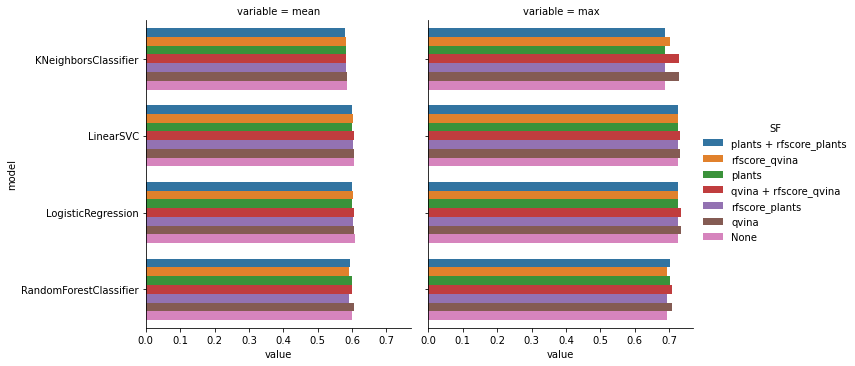

In [18]:
# Do the scores increase when I add the docking scoring functions?
sns.catplot(kind='bar', data=compare, y='model', x='value', col='variable', hue='SF')

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.     
<a id='roc_curves'></a>
### ROC curves

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

In [20]:
def get_train_test_scores(X_train, X_test, y_train, model_fitted):    
    y_pred_train = model_fitted.predict(X_train)
    y_pred_test = model_fitted.predict(X_test)

    scores = [accuracy_score(y_test, y_pred_test), # test_accuracy
              f1_score(y_test, y_pred_test), # test_f1
              precision_score(y_test, y_pred_test), # test_precision
              recall_score(y_test, y_pred_test), # test_recall
              roc_auc_score(y_test, y_pred_test), # test_roc_auc
              accuracy_score(y_train, y_pred_train), # train_accuracy
              f1_score(y_train, y_pred_train), # train_f1
              precision_score(y_train, y_pred_train), # train_precision
              recall_score(y_train, y_pred_train), # train_recall
              roc_auc_score(y_train, y_pred_train), # train_roc_auc
             ]
    
    return scores

In [21]:
# Top models' probabilities
train_data = pd.DataFrame()
test_data = pd.DataFrame()

subset = ['qvina','Volume','Rotatable Bonds','TPSA','Molecular Weight']
new_data = data.dropna(subset=subset)
y = new_data['r_active']
X = new_data[subset]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# Apply SMOTE to training data and keep original test data
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train)

model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                    CalibratedClassifierCV(LinearSVC(dual=False, random_state=13)), 
                    RandomForestClassifier(n_estimators=10, random_state=13), 
                    KNeighborsClassifier(n_neighbors=3)]
                    # LinearSVC doesn't have a "predict_proba" function, but sklearn provides 
                    # "CalibratedClassifierCV" for this purpose

# List with each top model's scores
scores_list = []

for model in model_list:
    model_fitted = model.fit(X_train, y_train)
    scores = get_train_test_scores(X_train, X_test, y_train, model_fitted)
    
    model_name = str(model)
    if 'LinearSVC' in model_name:
        model_name = 'LinearSVC'
    else:
        model_name = model_name.split('(')[0]
        
    scores_list.append([model_name, *scores])
    
    y_proba_train = model_fitted.predict_proba(X_train)
    train_data[model_name] = y_proba_train[:,1]

    y_proba_test = model_fitted.predict_proba(X_test)
    test_data[model_name] = y_proba_test[:,1]
    
    # Keep original indices
    test_data.index = X_test.index

test_metrics = ['test_'+ i for i in scoring_metrics]
train_metrics = ['train_'+ i for i in scoring_metrics]
columns = ['model', *test_metrics, *train_metrics]

top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics].mean(axis=1)

,model,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_accuracy,train_f1,train_precision,train_recall,train_roc_auc,test_mean,train_mean
0,LogisticRegression,0.703390,0.385965,0.268293,0.68750,0.696691,0.704809,0.703333,0.706868,0.699834,0.704809,0.548368,0.703931
1,LinearSVC,0.699153,0.382609,0.265060,0.68750,0.694240,0.715589,0.717695,0.712418,0.723051,0.715589,0.545712,0.716869
2,RandomForestClassifier,0.758475,0.240000,0.209302,0.28125,0.557292,0.991708,0.991708,0.991708,0.991708,0.991708,0.409264,0.991708
3,KNeighborsClassifier,0.627119,0.185185,0.131579,0.31250,0.494485,0.906302,0.911788,0.861357,0.968491,0.906302,0.350174,0.910848


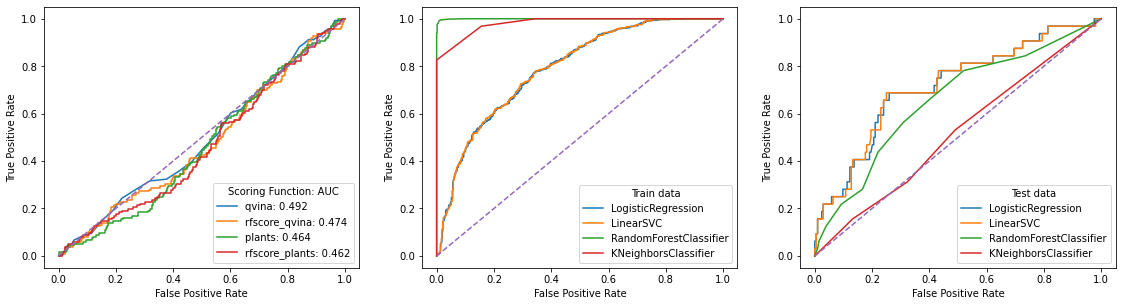

In [22]:
fig, ax = plt.subplots(ncols=3, figsize=(19.2, 4.8))

# Plot ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data['r_active'].values, data[SF].values)
    ax[0].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot ROC curves for the ML models
for model_name in test_data.columns:
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[1].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[2].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(3):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Scoring Function: AUC', loc='lower right')
ax[1].legend(title='Train data')
ax[2].legend(title='Test data')
plt.savefig('roc_auc.png')

top_scores

In [23]:
new_scores_data.sort_values('test_mean', ascending=False).groupby('model').head(1)

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,activity_label,model,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
3512,0.744416,0.397669,0.295948,0.609972,0.726020,f_active,KNeighborsClassifier,0,1,1,0,1,1,1,0,0,0.554805
5956,0.822881,0.405662,0.394776,0.419312,0.701409,r_active,RandomForestClassifier,1,1,1,1,0,0,0,1,0,0.548808
3808,0.702026,0.385764,0.276166,0.646825,0.731529,r_active,LogisticRegression,1,1,1,1,1,1,1,0,0,0.548462
2124,0.698818,0.375315,0.269300,0.624603,0.726159,r_active,LinearSVC,1,0,1,1,1,0,0,0,0,0.538839


In [24]:
top_scores

,model,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_accuracy,train_f1,train_precision,train_recall,train_roc_auc,test_mean,train_mean
0,LogisticRegression,0.703390,0.385965,0.268293,0.68750,0.696691,0.704809,0.703333,0.706868,0.699834,0.704809,0.548368,0.703931
1,LinearSVC,0.699153,0.382609,0.265060,0.68750,0.694240,0.715589,0.717695,0.712418,0.723051,0.715589,0.545712,0.716869
2,RandomForestClassifier,0.758475,0.240000,0.209302,0.28125,0.557292,0.991708,0.991708,0.991708,0.991708,0.991708,0.409264,0.991708
3,KNeighborsClassifier,0.627119,0.185185,0.131579,0.31250,0.494485,0.906302,0.911788,0.861357,0.968491,0.906302,0.350174,0.910848


We can see that Logistic Regression and Linear SVC were the best models and that they yielded very similar results.         
Considering Logistic Regression is the most frequent one in the top scores, we can assume it is the most adequate model for our problem.

In [25]:
test_data['CID'] = data.loc[test_data.index]['CID']
tmp = pd.melt(test_data, id_vars=['CID'], value_vars=test_data.columns[:-1])
tmp = tmp.append(pd.melt(data.loc[test_data.index], id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants']))
df_tidy = pd.merge(data.loc[test_data.index][['CID','r_inhibition_at_50_uM']], tmp, on=['CID'])

del tmp

Text(0.5, 0.98, 'Regression plots for the test set')

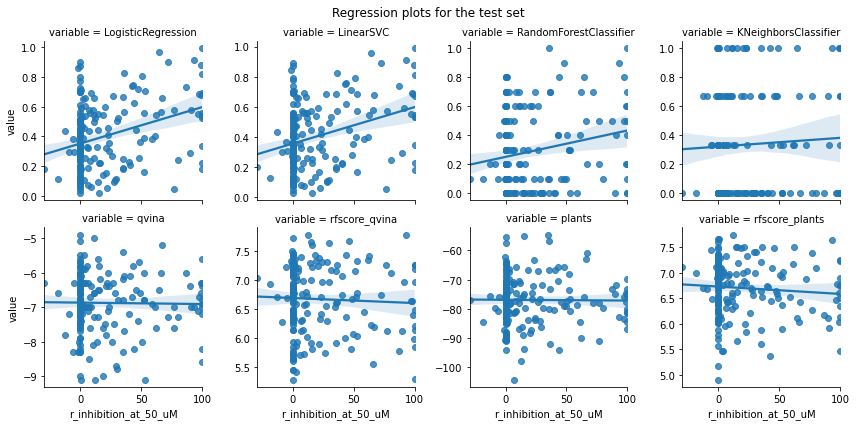

In [26]:
g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'r_inhibition_at_50_uM', 'value')

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Regression plots for the test set')

In [27]:
# Pearson correlations with "r_inhibition_at_50_uM"
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM'], columns='variable',values='value').reset_index().corr()['r_inhibition_at_50_uM']

variable
r_inhibition_at_50_uM     1.000000
KNeighborsClassifier      0.050881
LinearSVC                 0.335891
LogisticRegression        0.334246
RandomForestClassifier    0.214554
plants                   -0.009911
qvina                    -0.015455
rfscore_plants           -0.083391
rfscore_qvina            -0.047602
Name: r_inhibition_at_50_uM, dtype: float64

In [28]:
xgb_scores = get_mean_scores(data, 
                             train_set=['qvina','rfscore_qvina','plants','rfscore_plants','Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP'], 
                             scoring_metrics=scoring_metrics, 
                             subset=['qvina','Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP'], 
                             activity_label='r_active', 
                             model=XGBRegressor(objective='reg:squarederror', random_state=13))

#pd.DataFrame([xgb_scores], columns=['fit_time','score_time','test_accuracy','test_f1','test_precision',
#         'test_recall','test_roc_auc','model','scaler','subset'])#

/home/caio/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/caio/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/caio/miniconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/home/caio/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 504, in fit
    train_dmatrix = DMatrix(data=X, label=y, weight=sample_weight,
  File "/home/caio/miniconda3/lib/python3.8/site-packages/xgboost/core.py", line 434, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "/home/caio/miniconda3/lib/python3.8/site-packages/xgboost/data.py", line 503, i

# Supplementary data

In [29]:
scores_data.groupby(['model','scaler','activity_label']).describe()['test_roc_auc']

count      mean  \
model                  scaler         activity_label                    
KNeighborsClassifier   MinMaxScaler   f_active        214.0  0.604072   
                                      r_active        214.0  0.589821   
                       None           f_active        214.0  0.582513   
                                      r_active        214.0  0.579742   
                       RobustScaler   f_active        214.0  0.605861   
                                      r_active        214.0  0.591173   
                       StandardScaler f_active        214.0  0.606508   
                                      r_active        214.0  0.591428   
LinearSVC              MinMaxScaler   f_active        214.0  0.581053   
                                      r_active        214.0  0.615481   
                       None           f_active        214.0  0.583757   
                                      r_active        214.0  0.619307   
                       RobustScaler   f_active        214.0  0.582270   
                                      r_active        214.0  0.617969   
                       StandardScaler f_active        214.0  0.582563   
                                      r_active        214.0  0.618024   
LogisticRegression     MinMaxScaler   f_active        214.0  0.575771   
                                      r_active        214.0  0.603056   
                       None           f_active        214.0  0.585127   
                                      r_active        214.0  0.620010   
                       RobustScaler   f_active        214.0  0.581809   
                                      r_active        214.0  0.617387   
                       StandardScaler f_active        214.0  0.582356   
                                      r_active        214.0  0.617868   
RandomForestClassifier MinMaxScaler   f_active        214.0  0.601026   
                                      r_active        214.0  0.589619   
                       None           f_active        214.0  0.601904   
                                      r_active        214.0  0.591498   
                       RobustScaler   f_active        214.0  0.604881   
                                      r_active        214.0  0.590235   
                       StandardScaler f_active        214.0  0.604479   
                                      r_active        214.0  0.588274   

                                                           std       min  \
model                  scaler         activity_label                       
KNeighborsClassifier   MinMaxScaler   f_active        0.057561  0.435380   
                                      r_active        0.047411  0.456196   
                       None           f_active        0.051715  0.425871   
                                      r_active        0.040984  0.449928   
                       RobustScaler   f_active        0.061952  0.437571   
                                      r_active        0.049086  0.452122   
                       StandardScaler f_active        0.061278  0.438830   
                                      r_active        0.049181  0.453041   
LinearSVC              MinMaxScaler   f_active        0.075777  0.412010   
                                      r_active        0.070052  0.429754   
                       None           f_active        0.071963  0.409333   
                                      r_active        0.068547  0.438081   
                       RobustScaler   f_active        0.077201  0.412696   
                                      r_active        0.070990  0.430029   
                       StandardScaler f_active        0.077098  0.412082   
                                      r_active        0.070966  0.430172   
LogisticRegression     MinMaxScaler   f_active        0.074269  0.412139   
                                      r_active        0.065372  0.430790   
                       None           f_active     

In [30]:
# Guardar resultados com cada descritor
# Comparar automatizado

In [31]:
# Pesquisar sobre elbow method
# Pesquisar sobre metricas
# Importar rdkit e calcular dentro do notebook